In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option("display.max_columns",999)
pd.set_option('display.max_rows', 20)
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)

In [2]:
#Lectura Datasets

In [3]:
sivigila=pd.read_parquet('../parquet_datasets/sivigila_2017_2018_S.parquet')
sivigila

,DEPARTAMENTO,ENFERMEDAD,FECHA,EDAD,SEXO
0,NORTE SANTANDER,CHAGAS,2017-08-01,46,M
1,BOYACA,CHAGAS,2017-05-01,87,F
2,TOLIMA,CHAGAS,2017-09-01,58,F
3,SANTANDER,CHAGAS,2017-08-01,68,F
4,CUNDINAMARCA,CHAGAS,2017-10-01,70,F
...,...,...,...,...,...
141005,VALLE,ZIKA,2018-07-01,36,M
141006,VALLE,ZIKA,2018-09-01,51,M
141007,VALLE,ZIKA,2018-05-01,38,F
141008,VALLE,ZIKA,2019-03-01,47,M


In [4]:
medicos_ips=pd.read_parquet('../parquet_datasets/medicos_ips_S.parquet')
medicos_ips.columns=['DEPARTAMENTO','FECHA_APERTURA','CODIGO','TIPO']
medicos_ips

,DEPARTAMENTO,FECHA_APERTURA,CODIGO,TIPO
259039,Valle del cauca,2002-03-01,7600100828,Profesional Independiente
200641,Meta,2002-12-01,5057300003,Instituciones - IPS
200643,Meta,2002-12-01,5057300003,Instituciones - IPS
56015,Bogotá D.C,2002-12-01,1100100021,Profesional Independiente
200634,Meta,2002-12-01,5057300003,Instituciones - IPS
...,...,...,...,...
188268,Magdalena,2020-11-01,4700100508,Instituciones - IPS
187124,Magdalena,2020-11-01,4700100071,Instituciones - IPS
187121,Magdalena,2020-11-01,4700100071,Instituciones - IPS
143248,Cesar,2020-11-01,2000102062,Instituciones - IPS


In [5]:
nofetal=pd.read_parquet('../parquet_datasets/Nofetal_S.parquet')
nofetal.columns=['FECHA','DEPARTAMENTO','SEXO','GRUPO_EDAD']
nofetal=nofetal[['DEPARTAMENTO','FECHA','GRUPO_EDAD','SEXO']]
nofetal

,DEPARTAMENTO,FECHA,GRUPO_EDAD,SEXO
0,Putumayo,2017-01-01,De 50 a 54 años,Masculino
1,Putumayo,2017-01-01,De 25 a 29 años,Masculino
2,Antioquia,2017-01-01,De 35 a 39 años,Masculino
3,Antioquia,2017-01-01,De 45 a 49 años,Masculino
4,Cauca,2017-01-01,De 30 a 34 años,Masculino
...,...,...,...,...
464551,Sucre,2018-04-01,De 50 a 54 años,Masculino
464552,Risaralda,2018-12-01,De 70 a 74 años,Masculino
464553,Risaralda,2018-12-01,De 90 a 94 años,Masculino
464554,Santander,2018-07-01,De 80 a 84 años,Femenino


In [6]:
#Lista valores departamentos

In [7]:
dep_sivigila=sorted(list(sivigila.DEPARTAMENTO.unique()))
dep_sivigila

['AMAZONAS',
 'ANTIOQUIA',
 'ARAUCA',
 'ATLANTICO',
 'BOGOTA',
 'BOLIVAR',
 'BOYACA',
 'CALDAS',
 'CAQUETA',
 'CASANARE',
 'CAUCA',
 'CESAR',
 'CHOCO',
 'CORDOBA',
 'CUNDINAMARCA',
 'GUAINIA',
 'GUAJIRA',
 'GUAVIARE',
 'HUILA',
 'MAGDALENA',
 'META',
 'NARIÑO',
 'NORTE SANTANDER',
 'PUTUMAYO',
 'QUINDIO',
 'RISARALDA',
 'SAN ANDRES',
 'SANTANDER',
 'SUCRE',
 'TOLIMA',
 'VALLE',
 'VAUPES',
 'VICHADA']

In [8]:
dep_med_ips=sorted(list(medicos_ips.DEPARTAMENTO.unique()))
dep_med_ips

['Amazonas',
 'Antioquia',
 'Arauca',
 'Atlántico',
 'Bogotá D.C',
 'Bolívar',
 'Boyacá',
 'Caldas',
 'Caquetá',
 'Casanare',
 'Cauca',
 'Cesar',
 'Chocó',
 'Cundinamarca',
 'Córdoba',
 'Guainía',
 'Guaviare',
 'Huila',
 'La Guajira',
 'Magdalena',
 'Meta',
 'Nariño',
 'Norte de Santander',
 'Putumayo',
 'Quindío',
 'Risaralda',
 'San Andrés y Providencia',
 'Santander',
 'Sucre',
 'Tolima',
 'Valle del cauca',
 'Vaupés',
 'Vichada']

In [9]:
dep_nofetal=sorted(list(nofetal.DEPARTAMENTO.unique()))
dep_nofetal

['Amazonas',
 'Antioquia',
 'Arauca',
 'Atlántico',
 'Bogotá',
 'Bolivar',
 'Boyaca',
 'Caldas',
 'Caqueta',
 'Casanare',
 'Cauca',
 'Cesar',
 'Choco',
 'Cordoba',
 'Cundinamarca',
 'Guainía',
 'Guaviare',
 'Huila',
 'La guajira',
 'Magdalena',
 'Meta',
 'Nariño',
 'Norte de Santander',
 'Putumayo',
 'Quindio',
 'Risaralda',
 'San Andrés y Providencia',
 'Santander',
 'Sucre',
 'Tolima',
 'Valle del Cauca',
 'Vaupés',
 'Vichada']

In [10]:
# funcion que devuelve el string mas parecido
from fuzzywuzzy import process
def dep_finder(DEPARTAMENTO, data_list):
    closest_match = process.extractOne(DEPARTAMENTO,data_list)
    return closest_match[0]

In [11]:
from collections import defaultdict

In [12]:
dep_dic1=defaultdict(str)

In [13]:
for i in dep_sivigila:
    j=dep_finder(i,dep_med_ips)
    dep_dic1[i]=j

In [14]:
dep_dic1

defaultdict(str,
            {'AMAZONAS': 'Amazonas',
             'ANTIOQUIA': 'Antioquia',
             'ARAUCA': 'Arauca',
             'ATLANTICO': 'Atlántico',
             'BOGOTA': 'Bogotá D.C',
             'BOLIVAR': 'Bolívar',
             'BOYACA': 'Boyacá',
             'CALDAS': 'Caldas',
             'CAQUETA': 'Caquetá',
             'CASANARE': 'Casanare',
             'CAUCA': 'Cauca',
             'CESAR': 'Cesar',
             'CHOCO': 'Chocó',
             'CORDOBA': 'Córdoba',
             'CUNDINAMARCA': 'Cundinamarca',
             'GUAINIA': 'Guainía',
             'GUAJIRA': 'La Guajira',
             'GUAVIARE': 'Guaviare',
             'HUILA': 'Huila',
             'MAGDALENA': 'Magdalena',
             'META': 'Meta',
             'NARIÑO': 'Nariño',
             'NORTE SANTANDER': 'Norte de Santander',
             'PUTUMAYO': 'Putumayo',
             'QUINDIO': 'Quindío',
             'RISARALDA': 'Risaralda',
             'SAN ANDRES': 'San Andrés y Prov

In [15]:
dep_dic2=defaultdict(str)

In [16]:
for i in dep_nofetal:
    j=dep_finder(i,dep_med_ips)
    dep_dic2[i]=j

In [17]:
dep_dic2

defaultdict(str,
            {'Amazonas': 'Amazonas',
             'Antioquia': 'Antioquia',
             'Arauca': 'Arauca',
             'Atlántico': 'Atlántico',
             'Bogotá': 'Bogotá D.C',
             'Bolivar': 'Bolívar',
             'Boyaca': 'Boyacá',
             'Caldas': 'Caldas',
             'Caqueta': 'Caquetá',
             'Casanare': 'Casanare',
             'Cauca': 'Cauca',
             'Cesar': 'Cesar',
             'Choco': 'Chocó',
             'Cordoba': 'Córdoba',
             'Cundinamarca': 'Cundinamarca',
             'Guainía': 'Guainía',
             'Guaviare': 'Guaviare',
             'Huila': 'Huila',
             'La guajira': 'La Guajira',
             'Magdalena': 'Magdalena',
             'Meta': 'Meta',
             'Nariño': 'Nariño',
             'Norte de Santander': 'Norte de Santander',
             'Putumayo': 'Putumayo',
             'Quindio': 'Quindío',
             'Risaralda': 'Risaralda',
             'San Andrés y Providencia'

In [18]:
sivigila['DEPARTAMENTO'] = sivigila.apply(lambda x: dep_dic1[x['DEPARTAMENTO']],axis=1)
sivigila.DEPARTAMENTO=sivigila.DEPARTAMENTO.astype('category')
sivigila

,DEPARTAMENTO,ENFERMEDAD,FECHA,EDAD,SEXO
0,Norte de Santander,CHAGAS,2017-08-01,46,M
1,Boyacá,CHAGAS,2017-05-01,87,F
2,Tolima,CHAGAS,2017-09-01,58,F
3,Santander,CHAGAS,2017-08-01,68,F
4,Cundinamarca,CHAGAS,2017-10-01,70,F
...,...,...,...,...,...
141005,Valle del cauca,ZIKA,2018-07-01,36,M
141006,Valle del cauca,ZIKA,2018-09-01,51,M
141007,Valle del cauca,ZIKA,2018-05-01,38,F
141008,Valle del cauca,ZIKA,2019-03-01,47,M


In [19]:
nofetal['DEPARTAMENTO'] = nofetal.apply(lambda x: dep_dic2[x['DEPARTAMENTO']],axis=1)
nofetal.DEPARTAMENTO=nofetal.DEPARTAMENTO.astype('category')
nofetal

,DEPARTAMENTO,FECHA,GRUPO_EDAD,SEXO
0,Putumayo,2017-01-01,De 50 a 54 años,Masculino
1,Putumayo,2017-01-01,De 25 a 29 años,Masculino
2,Antioquia,2017-01-01,De 35 a 39 años,Masculino
3,Antioquia,2017-01-01,De 45 a 49 años,Masculino
4,Cauca,2017-01-01,De 30 a 34 años,Masculino
...,...,...,...,...
464551,Sucre,2018-04-01,De 50 a 54 años,Masculino
464552,Risaralda,2018-12-01,De 70 a 74 años,Masculino
464553,Risaralda,2018-12-01,De 90 a 94 años,Masculino
464554,Santander,2018-07-01,De 80 a 84 años,Femenino


In [20]:
medicos_ips

,DEPARTAMENTO,FECHA_APERTURA,CODIGO,TIPO
259039,Valle del cauca,2002-03-01,7600100828,Profesional Independiente
200641,Meta,2002-12-01,5057300003,Instituciones - IPS
200643,Meta,2002-12-01,5057300003,Instituciones - IPS
56015,Bogotá D.C,2002-12-01,1100100021,Profesional Independiente
200634,Meta,2002-12-01,5057300003,Instituciones - IPS
...,...,...,...,...
188268,Magdalena,2020-11-01,4700100508,Instituciones - IPS
187124,Magdalena,2020-11-01,4700100071,Instituciones - IPS
187121,Magdalena,2020-11-01,4700100071,Instituciones - IPS
143248,Cesar,2020-11-01,2000102062,Instituciones - IPS


In [21]:
medicos_ips['AÑO']= medicos_ips.FECHA_APERTURA.dt.strftime('%Y')

In [22]:
medicos_ips_agg=medicos_ips.groupby(['DEPARTAMENTO','TIPO','AÑO'])\
    .agg(TOTAL_ACUMULADO=('CODIGO','count'))\
    .groupby(level=[0,1]).cumsum().reset_index()
medicos_ips_agg

,DEPARTAMENTO,TIPO,AÑO,TOTAL_ACUMULADO
0,Amazonas,Instituciones - IPS,2002,0
1,Amazonas,Instituciones - IPS,2003,6
2,Amazonas,Instituciones - IPS,2004,6
3,Amazonas,Instituciones - IPS,2005,6
4,Amazonas,Instituciones - IPS,2006,6
...,...,...,...,...
1249,Vichada,Profesional Independiente,2016,0
1250,Vichada,Profesional Independiente,2017,2
1251,Vichada,Profesional Independiente,2018,2
1252,Vichada,Profesional Independiente,2019,2


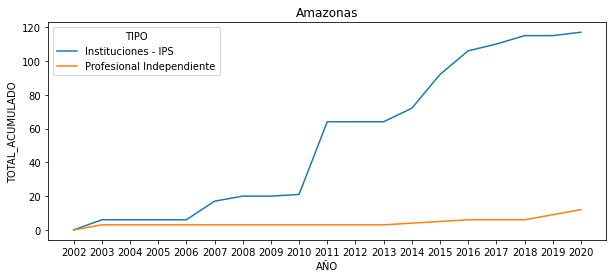

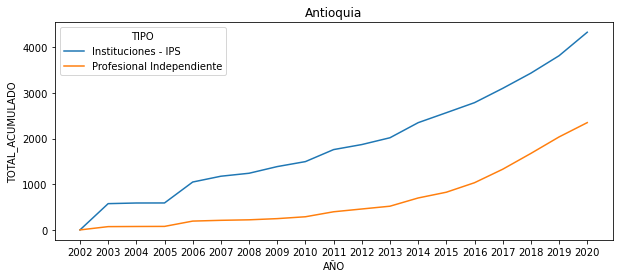

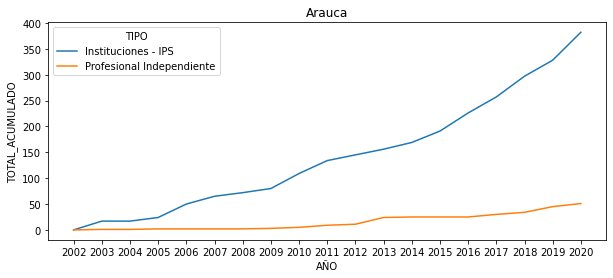

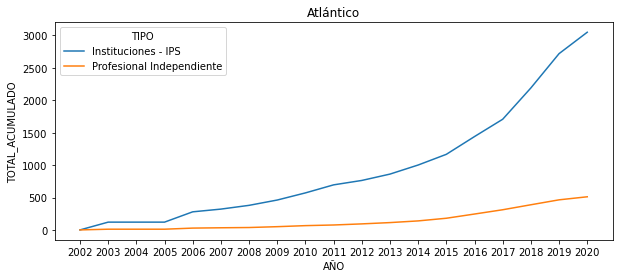

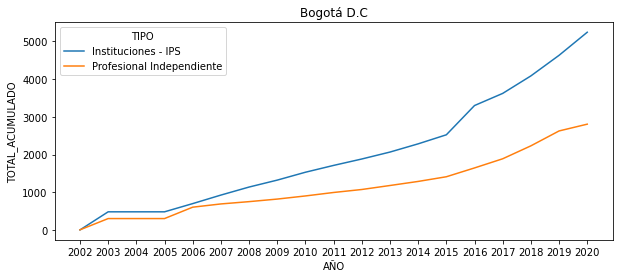

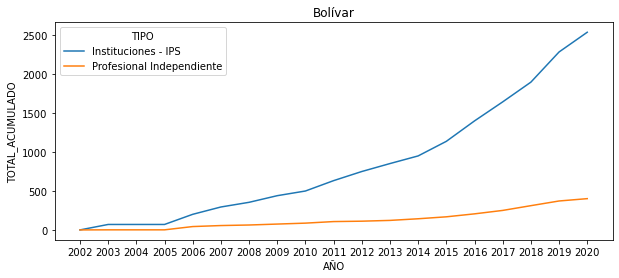

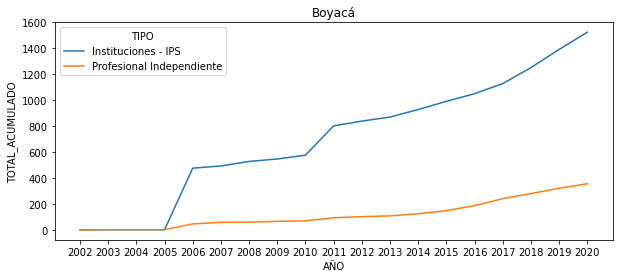

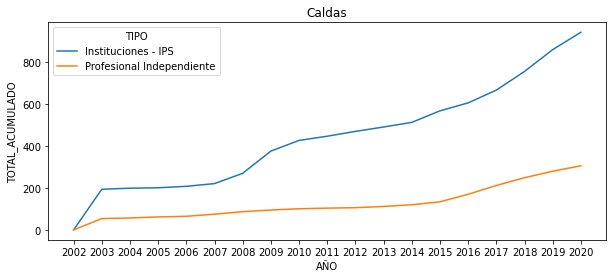

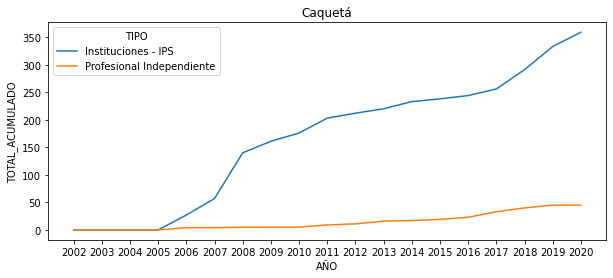

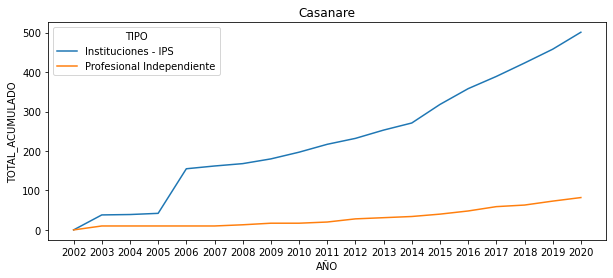

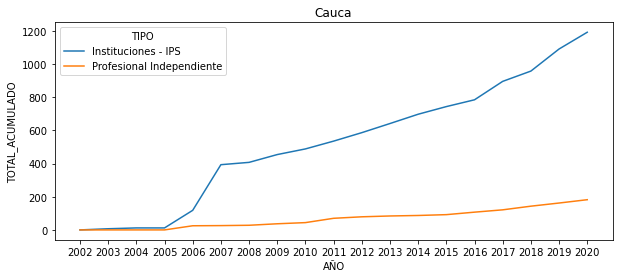

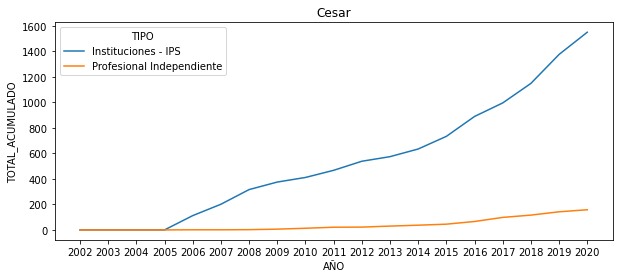

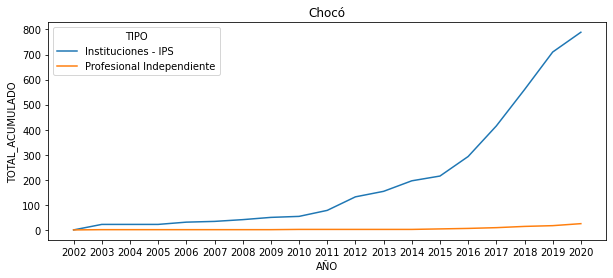

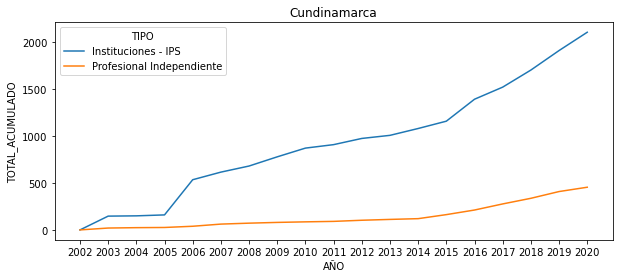

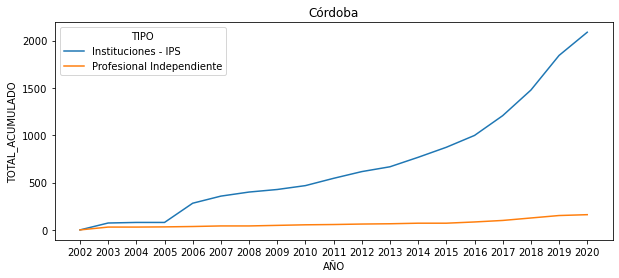

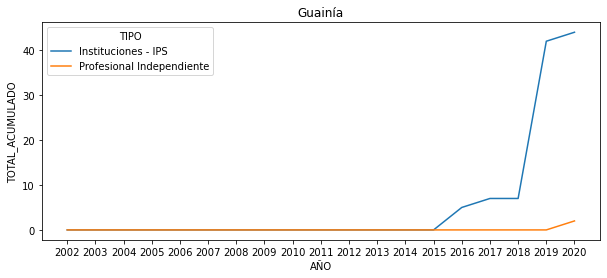

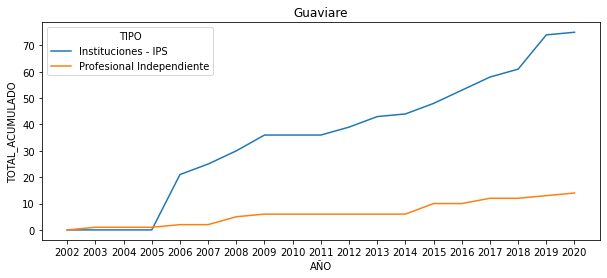

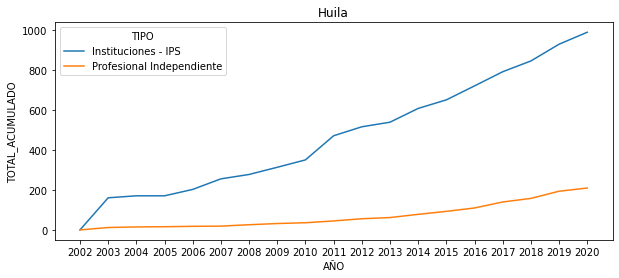

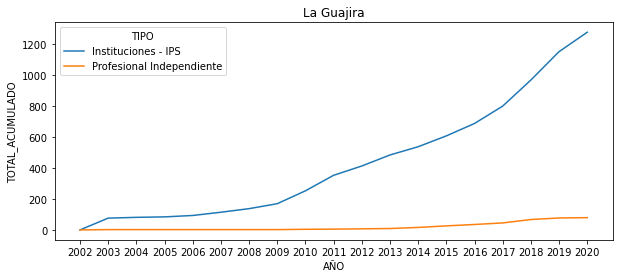

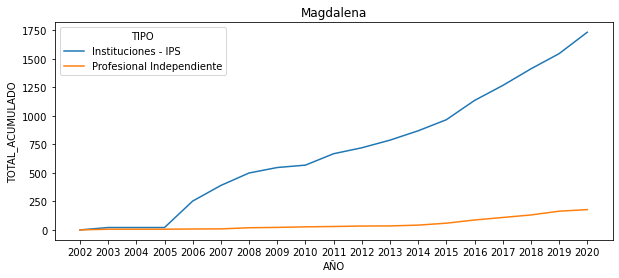

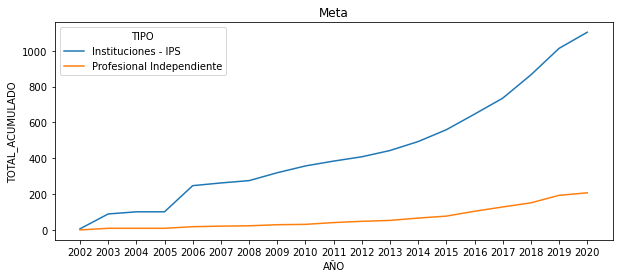

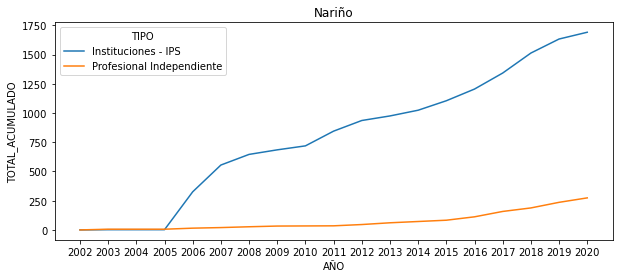

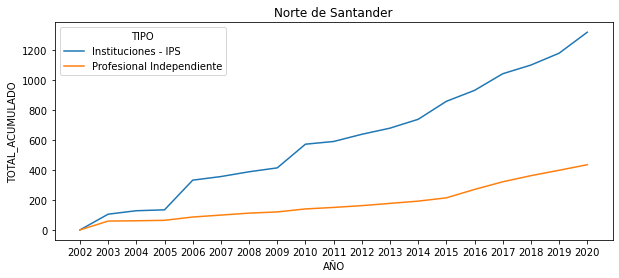

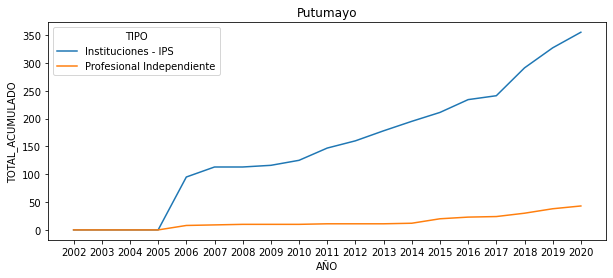

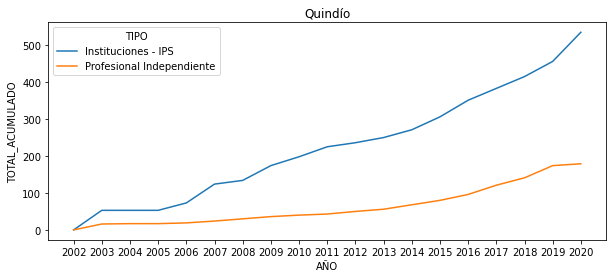

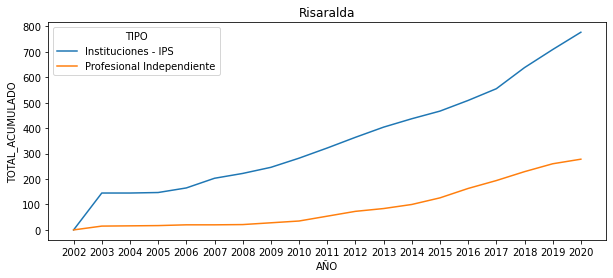

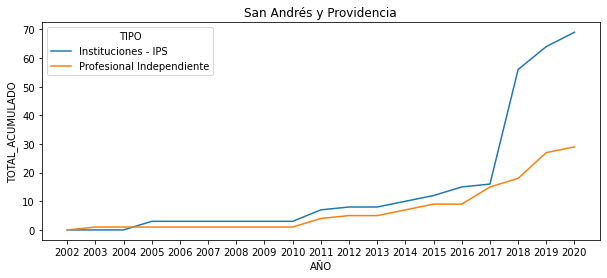

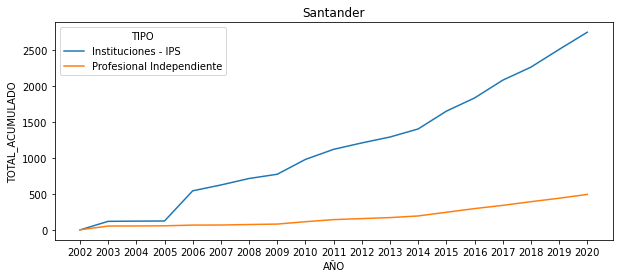

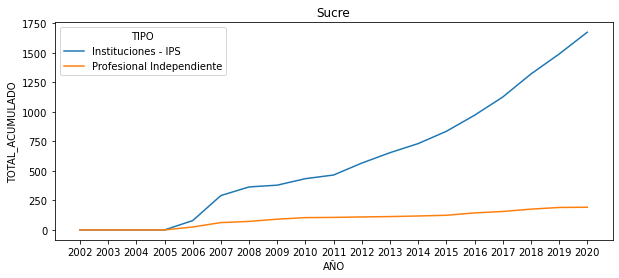

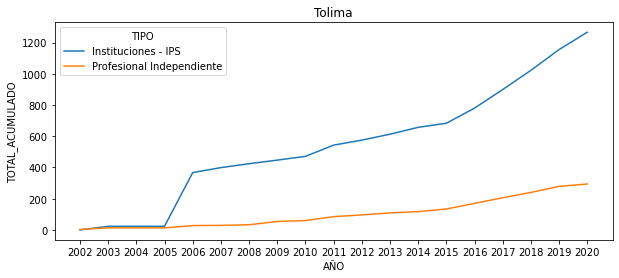

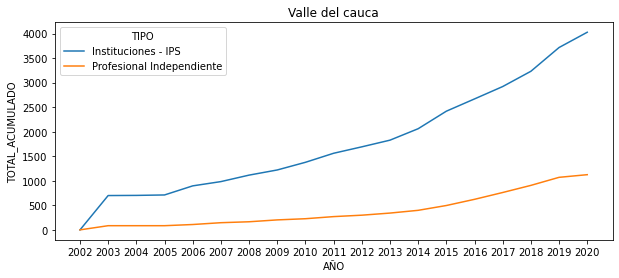

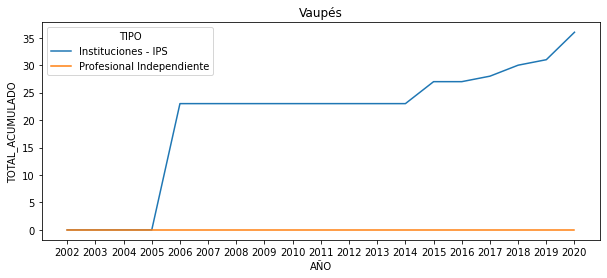

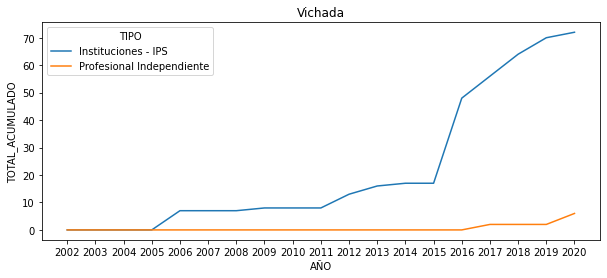

In [23]:
for i in medicos_ips_agg.DEPARTAMENTO.unique():
    fig= plt.figure(figsize=(10,4))
    sns.lineplot(data=medicos_ips_agg[medicos_ips_agg.DEPARTAMENTO==i]\
                 ,x='AÑO', y='TOTAL_ACUMULADO', hue='TIPO');
    plt.title(i);

In [24]:
medicos_ips_agg_2=medicos_ips.groupby(['TIPO','AÑO'])\
    .agg(TOTAL_ACUMULADO=('CODIGO','count'))\
    .groupby(level=[0]).cumsum().reset_index()
medicos_ips_agg_2

,TIPO,AÑO,TOTAL_ACUMULADO
0,Instituciones - IPS,2002,6
1,Instituciones - IPS,2003,3244
2,Instituciones - IPS,2004,3334
3,Instituciones - IPS,2005,3382
4,Instituciones - IPS,2006,7952
...,...,...,...
33,Profesional Independiente,2016,6314
34,Profesional Independiente,2017,7696
35,Profesional Independiente,2018,9215
36,Profesional Independiente,2019,10906


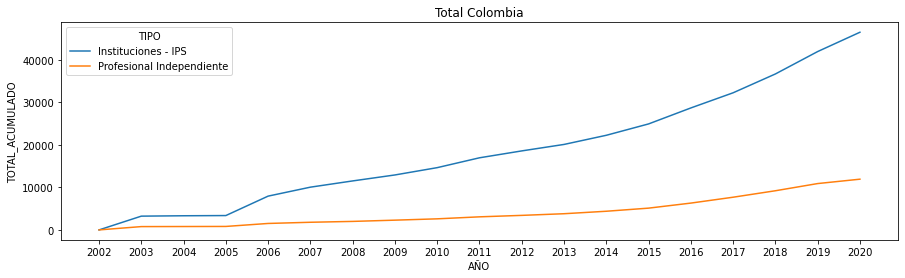

In [25]:
fig= plt.figure(figsize=(15,4))
sns.lineplot(data=medicos_ips_agg_2\
             ,x='AÑO', y='TOTAL_ACUMULADO', hue='TIPO');
plt.title('Total Colombia');

In [26]:
medicos_ips['MES']= medicos_ips.FECHA_APERTURA.dt.strftime('%Y-%m')

In [27]:
medicos_ips_agg_3=medicos_ips.groupby(['TIPO','MES'])\
    .agg(TOTAL_ACUMULADO=('CODIGO','count'))\
    .groupby(level=[0]).cumsum().reset_index()
medicos_ips_agg_3

,TIPO,MES,TOTAL_ACUMULADO
0,Instituciones - IPS,2002-03,0
1,Instituciones - IPS,2002-12,6
2,Instituciones - IPS,2003-01,34
3,Instituciones - IPS,2003-02,120
4,Instituciones - IPS,2003-03,535
...,...,...,...
429,Profesional Independiente,2020-07,11457
430,Profesional Independiente,2020-08,11543
431,Profesional Independiente,2020-09,11713
432,Profesional Independiente,2020-10,11821


In [28]:
from matplotlib.dates import date2num, num2date

In [29]:
medicos_ips_agg_3=medicos_ips_agg_3.assign(DATE_NUM=date2num(medicos_ips_agg_3['MES']))
medicos_ips_agg_3

,TIPO,MES,TOTAL_ACUMULADO,DATE_NUM
0,Instituciones - IPS,2002-03,0,11747.0
1,Instituciones - IPS,2002-12,6,12022.0
2,Instituciones - IPS,2003-01,34,12053.0
3,Instituciones - IPS,2003-02,120,12084.0
4,Instituciones - IPS,2003-03,535,12112.0
...,...,...,...,...
429,Profesional Independiente,2020-07,11457,18444.0
430,Profesional Independiente,2020-08,11543,18475.0
431,Profesional Independiente,2020-09,11713,18506.0
432,Profesional Independiente,2020-10,11821,18536.0


In [30]:
MES_TEST=pd.period_range(start='2020-11', periods=124, freq='M').to_timestamp()

In [31]:
MES_TEST=pd.Series(MES_TEST).dt.strftime('%Y-%m')
MES_TEST_NUM=date2num(MES_TEST)

In [32]:
medicos_ips_agg_3_ips=medicos_ips_agg_3[medicos_ips_agg_3.TIPO== 'Instituciones - IPS']
medicos_ips_agg_3_med=medicos_ips_agg_3[medicos_ips_agg_3.TIPO== 'Profesional Independiente']


In [33]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

In [34]:
x_train=np.array(medicos_ips_agg_3_ips['DATE_NUM']).reshape(-1, 1)
y_train=np.array(medicos_ips_agg_3_ips['TOTAL_ACUMULADO']).reshape(-1, 1)
# y_train=np.log1p(np.array(medicos_ips_agg_3_ips['TOTAL_ACUMULADO']).reshape(-1, 1))

In [35]:
x_future=np.array(MES_TEST_NUM).reshape(-1, 1)
lin_reg.fit(x_train,y_train)
y_pred=lin_reg.predict(x_train)
y_future=lin_reg.predict(x_future)

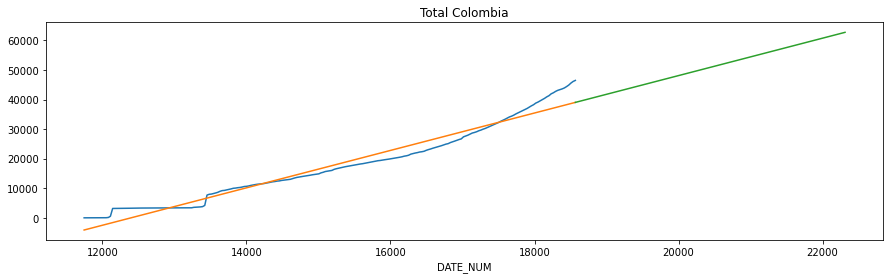

In [36]:
fig= plt.figure(figsize=(15,4))
sns.lineplot(x=medicos_ips_agg_3_ips['DATE_NUM'], y=y_train.flatten());
sns.lineplot(x=medicos_ips_agg_3_ips['DATE_NUM'], y=y_pred.flatten());
sns.lineplot(x=MES_TEST_NUM, y=y_future.flatten());
plt.title('Total Colombia');

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())


In [38]:
polyreg.fit(x_train,y_train)
y_pred=polyreg.predict(x_train)
y_future=polyreg.predict(x_future)

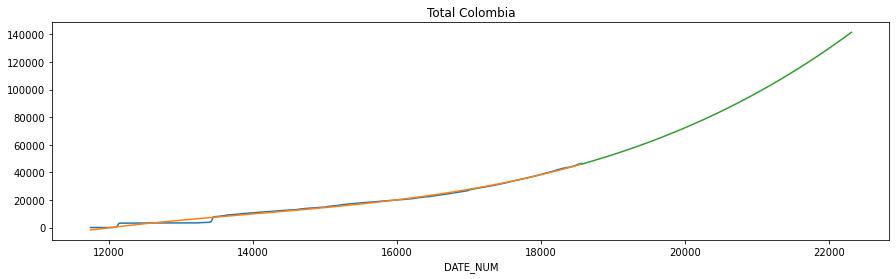

In [39]:
fig= plt.figure(figsize=(15,4))
sns.lineplot(x=medicos_ips_agg_3_ips['DATE_NUM'], y=y_train.flatten());
sns.lineplot(x=medicos_ips_agg_3_ips['DATE_NUM'], y=y_pred.flatten());
sns.lineplot(x=MES_TEST_NUM, y=y_future.flatten());
plt.title('Total Colombia');

In [40]:
# AHORA SOLO POR AÑO

In [41]:
medicos_ips_agg_2

,TIPO,AÑO,TOTAL_ACUMULADO
0,Instituciones - IPS,2002,6
1,Instituciones - IPS,2003,3244
2,Instituciones - IPS,2004,3334
3,Instituciones - IPS,2005,3382
4,Instituciones - IPS,2006,7952
...,...,...,...
33,Profesional Independiente,2016,6314
34,Profesional Independiente,2017,7696
35,Profesional Independiente,2018,9215
36,Profesional Independiente,2019,10906


In [42]:
YEAR_TEST=pd.period_range(start='2020-11', periods=5, freq='Y').to_timestamp()

In [43]:
YEAR_TEST=pd.Series(YEAR_TEST).dt.strftime('%Y')
YEAR_TEST

0    2020
1    2021
2    2022
3    2023
4    2024
dtype: object

In [44]:
medicos_ips_agg_2_ips=medicos_ips_agg_2[medicos_ips_agg_2.TIPO== 'Instituciones - IPS']
medicos_ips_agg_2_med=medicos_ips_agg_2[medicos_ips_agg_2.TIPO== 'Profesional Independiente']

In [45]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

In [46]:
x_train=np.array(medicos_ips_agg_2_ips['AÑO']).reshape(-1, 1)
y_train=np.array(medicos_ips_agg_2_ips['TOTAL_ACUMULADO']).reshape(-1, 1)
# y_train=np.log1p(np.array(medicos_ips_agg_3_ips['TOTAL_ACUMULADO']).reshape(-1, 1))

In [47]:
x_future=np.array(YEAR_TEST).reshape(-1, 1)
lin_reg.fit(x_train,y_train)
y_pred=lin_reg.predict(x_train)
y_future=lin_reg.predict(x_future)

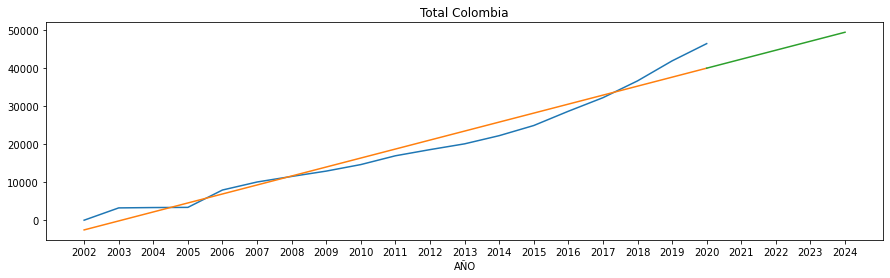

In [48]:
fig= plt.figure(figsize=(15,4))
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_train.flatten());
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_pred.flatten());
sns.lineplot(x=YEAR_TEST, y=y_future.flatten());
plt.title('Total Colombia');

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())


In [50]:
polyreg.fit(x_train,y_train)
y_pred=polyreg.predict(x_train)
y_future=polyreg.predict(x_future)

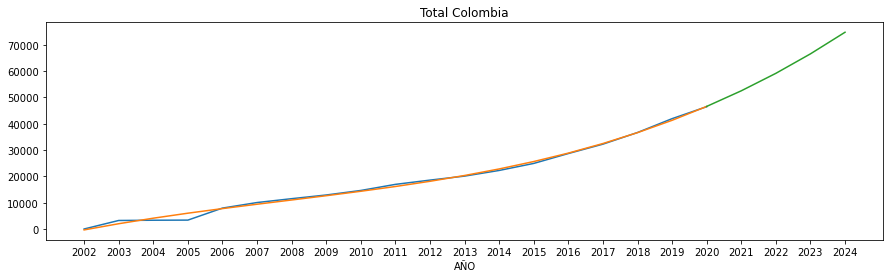

In [51]:
fig= plt.figure(figsize=(15,4))
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_train.flatten());
sns.lineplot(x=medicos_ips_agg_2_ips['AÑO'], y=y_pred.flatten());
sns.lineplot(x=YEAR_TEST, y=y_future.flatten());
plt.title('Total Colombia');